In [1]:
import torch_geometric
from torch_geometric.data import DataLoader
from torch_geometric.nn import MessagePassing,global_add_pool
from torch_geometric.utils import remove_self_loops
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from molecular_mpns.config import data_dir
from molecular_mpns.data import MolGraph
from molecular_mpns.proto_molecule import Molecule
from torch.optim.lr_scheduler import ExponentialLR

In [2]:
# define model

class ProtoMPN(MessagePassing):
    
    def __init__(self,h_dim):
        
        super(ProtoMPN,self).__init__(aggr = 'mean')
        
        self.h_dim = h_dim
        
        self.lin1 = torch.nn.Linear(1,h_dim)
        self.lin2 = torch.nn.Linear(h_dim,h_dim)
        self.lin3 = torch.nn.Linear(h_dim,h_dim)
        self.lin4 = torch.nn.Linear(h_dim,1)
        
    def forward(self,edge_index,x):
        
        edge_index, _ = remove_self_loops(edge_index)
        return self.propagate(edge_index = edge_index,x = x)
    
    def message(self,x_i,x_j):
        
        # compute distances
        dists = torch.sqrt(((x_i - x_j)**2).sum(dim=1,keepdim = True))
        
        # pass through nn
        h = self.lin1(dists)
        h = torch.nn.functional.silu(h)
        h = self.lin2(h)
        h = torch.nn.functional.silu(h)
        h = self.lin3(h)
        h = torch.nn.functional.silu(h)
        h = self.lin4(h)
        
        return h
    
    def update(self,aggr_out):
        return aggr_out

In [3]:
# define system

N = 5
beta = 15.0
kb = 1.0
rb = 2.0
ka = 1.0
ra = np.pi/2
kd = np.array([[0.02, 3], [0.02, 2]])
mol = Molecule(N, beta, kb, rb, ka, ra, kd)

# load data
traj = np.load(str(data_dir)+'/proto_mol_traj.npy')
pot_traj = np.array([mol._potential(x) for x in traj])
force_traj = np.array([mol._gradient(x) for x in traj])

In [15]:
# build model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mod = ProtoMPN(512)
mod = mod.double()
mod = mod.to(device)

reg_V,reg_dV = 1,1
opt = torch.optim.Adam(mod.parameters(),lr = 1e-4)
sched = ExponentialLR(opt, gamma = 0.995)

In [16]:
# train
epochs,batch_size = 100,32
clipping_value = 10
M = 2000000

for ep in range(epochs):
    ep_loss = 0
    
    # bootstrap sample equillibrium distribution
    np.random.seed(42)
    rand_idx = np.random.choice(M,10000)
    traj_train,pot_traj_train,force_traj_train = traj[rand_idx],pot_traj[rand_idx],force_traj[rand_idx]
    
    # compute graphs
    G_traj = [MolGraph(x,V,dV,requires_grad = True) for x,V,dV in zip(traj_train,pot_traj_train,force_traj_train)]
    loader = DataLoader(G_traj,batch_size = batch_size)
    
    for G_batch in loader:
        G_batch = G_batch.to(device)
        
        Vtheta = mod(G_batch.edge_index,G_batch.x)
        Vtheta = global_add_pool(Vtheta,G_batch.batch)
        
        Vtheta_batch = Vtheta.sum()
        dVtheta = torch.autograd.grad(Vtheta_batch,G_batch.x,create_graph = True)[0]
        
        V = G_batch.V.view(Vtheta.shape[0],1)
        dV = G_batch.dV
        
        loss = reg_V*torch.mean((Vtheta - V)**2)+reg_dV*torch.nn.MSELoss()(dV,dVtheta)
        ep_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm(mod.parameters(), clipping_value)
        opt.step()
        opt.zero_grad()
    
    sched.step()
    print('Epoch ' + str(ep+1) + ' Loss: ' + str(ep_loss))

<ipython-input-16-8615f3b813b2>:34: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(mod.parameters(), clipping_value)


Epoch 1 Loss: 25.763019627058323
Epoch 2 Loss: 21.06433612272414
Epoch 3 Loss: 19.178274022853508
Epoch 4 Loss: 18.72230383791305
Epoch 5 Loss: 18.46499477660135
Epoch 6 Loss: 18.34828773564677
Epoch 7 Loss: 18.25822630393635
Epoch 8 Loss: 18.168483306955277
Epoch 9 Loss: 18.113012672638284
Epoch 10 Loss: 18.084982106652035
Epoch 11 Loss: 18.069087276735115
Epoch 12 Loss: 18.055180191805427
Epoch 13 Loss: 18.04470345823062
Epoch 14 Loss: 18.036778074922022
Epoch 15 Loss: 18.03324931255769
Epoch 16 Loss: 18.02720758117399
Epoch 17 Loss: 18.023823606539477
Epoch 18 Loss: 18.01796211137316
Epoch 19 Loss: 18.017735211142533
Epoch 20 Loss: 18.012224457868374
Epoch 21 Loss: 18.0084926558488
Epoch 22 Loss: 18.005796304896048
Epoch 23 Loss: 18.000319766040835
Epoch 24 Loss: 17.996912798230596
Epoch 25 Loss: 17.991814495387057
Epoch 26 Loss: 17.990781780181017
Epoch 27 Loss: 17.987537998318995
Epoch 28 Loss: 17.987031337375285
Epoch 29 Loss: 17.987921838714
Epoch 30 Loss: 17.983804327688176
Epo

In [17]:
# validation trajectory
x = traj[0]
V = mol._potential(x)
dV = mol._gradient(x)
val_steps = 100000
dt = 5e-3

G = MolGraph(x,V,dV,requires_grad = True).to(device)
dangles = np.zeros((val_steps,2))

np.random.seed(42)
for t in range(val_steps):
    Vtheta = mod(G.edge_index,G.x).sum()
    dVtheta = torch.autograd.grad(Vtheta,G.x)[0]
    dVtheta = dVtheta.detach().cpu().numpy()
    
    x = x - dVtheta*dt + np.sqrt(2*dt/beta)*np.random.randn(N,3)
    V = mol._potential(x)
    dV = mol._gradient(x)
    G = MolGraph(x,V,dV,requires_grad = True).to(device)
    
    dangles[t] = mol._internal_coordinates(x)[7:9]

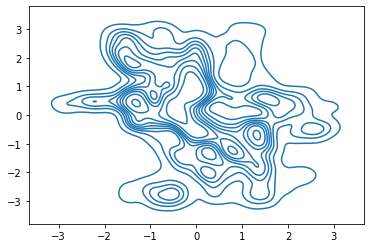

In [18]:
sns.kdeplot(x = dangles[:,0],y = dangles[:,1])
plt.show()
plt.close()